In [1]:
#load data
from decaf.scripts.imagenet import DecafNet
net = DecafNet('imagenet_pretrained/imagenet.decafnet.epoch90','imagenet_pretrained/imagenet.decafnet.meta')
import theano.tensor as T
from theano import function
import theano
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline


We STRONGLY recommend you to try to install mpi and mpi4py.



Couldn't import dot_parser, loading of dot files will not be possible.


In [10]:
from IPython.parallel import Client
client = Client()
client.block = True
view = client.load_balanced_view()
print len(client)

20


In [3]:
from glob import glob
X_im = [io.imread( name) for name in glob("../data/NEU surface defect database/*.bmp")]
from skimage import color
X_im = [color.rgb2gray(im) for im in X_im]
from skimage import img_as_ubyte
X_im = [img_as_ubyte(im) for im in X_im]

In [11]:
def feature_extractor(im):
    from decaf.scripts.imagenet import DecafNet
    net = DecafNet('imagenet_pretrained/imagenet.decafnet.epoch90','imagenet_pretrained/imagenet.decafnet.meta')
    layer = 'fc6_cudanet_out'
    scores = net.classify(im.astype('uint8'),center_only=True)
    feature = net.feature(layer)
    return feature.flatten()

In [7]:
import os
f_names = os.listdir("../data/NEU surface defect database/")
f_names.remove("Thumbs.db")
import numpy as np
labels = []
for name in f_names:
    labels.append(name.split('_')[0])
#transform labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(labels)

In [12]:
X = view.map(feature_extractor,X_im)

In [14]:
print len(X), X[0].shape
print labels[:3]

1800 (4096,)
['Pa', 'Pa', 'In']


In [18]:
Y = np.array(labels)
X = np.array(X)
print X.shape, Y.shape

(1800, 4096) (1800,)


In [19]:
from sklearn.cross_validation import train_test_split
train_x,test_x,train_y,test_y = train_test_split(np.array(X),Y,test_size =0.3)
print train_x.shape
print test_x.shape
print train_y.shape
print test_y.shape

(1260, 4096)
(540, 4096)
(1260,)
(540,)


In [20]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(train_x,train_y)
pred_y = classifier.predict(test_x)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print 'confusion_matrix'
print confusion_matrix(test_y,pred_y)
print 'accuracy'
print accuracy_score(test_y,pred_y)

confusion_matrix
[[ 92   0   0   0   0   0]
 [  0  87   1   0   0   0]
 [  0   0  84   0   0   0]
 [  0   0   0  83   0   0]
 [  0   0   0   0 101   0]
 [  0   0   0   0   0  92]]
accuracy
0.998148148148


In [22]:
classifier.predict(test_x)[0]

'Sc'

In [229]:
label_names = ['crazing','inclusion','pitted surface','patches','rolled-in scale','scratch']

In [24]:
import cPickle
with open("X_public.pkl","w") as f:
    cPickle.dump(X,f)
with open("Y_public.pkl","w") as f:
    cPickle.dump(Y,f)
# with open("labels_text.pkl","w") as f:
#     cPickle.dump(label_names,f)
with open("lg_classifier_public","w") as f:
    cPickle.dump(classifier,f)

In [14]:
plt.imread('public_data/'+f_names[0]).shape

(200, 200)

# Extra data

In [246]:
extra_names = os.listdir("extra_data/")
extra_names.remove("README.txt")

In [247]:
google_names = os.listdir("google_metal_surface/")

In [248]:
le.classes_

array(['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc', 'nan'], 
      dtype='|S3')

In [249]:
extra_labels = []
for name in extra_names:
    l = name.split('.')[0][:-1]
    if l == 'rs':
        l = 'RS'
    elif l == 'bp':
        l = 'Pa'
    elif l == 'scr':
        l = 'Sc'
    extra_labels.append(l)

In [251]:
ims_extra = [io.imread("extra_data/"+name) for name in extra_names]

In [253]:
X_extra = view.map(feature_extractor,ims_extra)

In [236]:
def feature_extractor(im):
    from decaf.scripts.imagenet import DecafNet
    net = DecafNet('imagenet_pretrained/imagenet.decafnet.epoch90','imagenet_pretrained/imagenet.decafnet.meta')
    layer = 'fc6_cudanet_out'
    scores = net.classify(im.astype('uint8'),center_only=True)
    feature = net.feature(layer)
    return feature.flatten()

In [252]:
google_labels = ['nan']*len(google_names)
ims_google = [io.imread("google_metal_surface/"+name) for name in google_names]


In [238]:
X_google = view.map(feature_extractor,ims_google)

In [179]:
print X_extra.shape, X.shape,X_google.shape
print len(extra_labels),len(labels),len(google_labels)

(58, 4096) (1800, 4096) (12, 4096)
58 1800 12


In [254]:
labels_all = le.fit_transform(labels + extra_labels + google_labels)
X_all = np.concatenate((X,X_extra, X_google))
#labels_all = le.fit_transform(labels  + google_labels)
#X_all = np.concatenate((X, X_google))

In [255]:
Counter(labels_all)

Counter({5: 307, 3: 305, 4: 305, 0: 300, 1: 300, 2: 300, 12: 12, 6: 5, 8: 4, 14: 4, 9: 3, 13: 3, 18: 3, 22: 3, 7: 2, 10: 2, 15: 2, 16: 2, 19: 2, 20: 2, 21: 2, 11: 1, 17: 1})

In [256]:
from sklearn.cross_validation import train_test_split
train_x,test_x,train_y,test_y = train_test_split(X_all,labels_all,test_size =0.3)
print train_x.shape
print test_x.shape
print train_y.shape
print test_y.shape

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(train_x,train_y)
pred_y = classifier.predict(test_x)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print 'confusion_matrix'
print confusion_matrix(test_y,pred_y)
print 'accuracy'
print accuracy_score(test_y,pred_y)

(1309, 4096)
(561, 4096)
(1309,)
(561,)
confusion_matrix
[[87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 79  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2 92  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 89  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 97  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 95  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0

In [262]:
print le.classes_

['Cr' 'In' 'PS' 'Pa' 'RS' 'Sc' 'anc' 'cb' 'hole' 'indent' 'ir_p' 'lami'
 'nan' 'par_bi' 'pm' 'roll_mark' 'rupture' 'rust' 'scab' 'sliv' 'spm'
 'undp' 'wav']


In [263]:
label_names = ['crazing','inclusion','pitted surface','patches','rolled-in scale','scratch','Anneal Color',
              'COIL BREAK','hole','indent','IRON PARTICLES','lamination','nan','PARALLEL BAND IMPRESSION',
              'PINCH MARK','roll mark', 'rupture','rust','scrab','sliver','spm_ii','under picking','waviness']

In [260]:
len(label_names)

23

In [264]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
#ind = np.where(labels_all == 2)[0]
#labels_all[ind] = 13
#ind = np.where(labels_all == 4)[0]
#labels_all[ind] = 13
classifier.fit(X_all,labels_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [265]:
le.classes_

array(['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc', 'anc', 'cb', 'hole', 'indent',
       'ir_p', 'lami', 'nan', 'par_bi', 'pm', 'roll_mark', 'rupture',
       'rust', 'scab', 'sliv', 'spm', 'undp', 'wav'], 
      dtype='|S9')

In [266]:
with open("labels_text_all.pkl","w") as f:
    cPickle.dump(label_names,f)
with open("lg_classifier_public_all","w") as f:
    cPickle.dump(classifier,f)

#AVI labels

In [15]:
avi_names = os.listdir("CleanAVIData/")
avi_names.remove("Dataset info v2.xlsx - Shortcut.lnk")
avi_names.remove("ReadMe.txt")

In [16]:
avi_labels = []
for name in avi_names:
    avi_labels.append(name.split('_')[-1].split('.')[0].split('(')[0].strip())

In [18]:
from collections import Counter
Counter(avi_labels)

Counter({'Scuff': 42, 'Dirt': 14, 'SecondaryGrain': 11, 'PlusMetal': 10, 'Sliver': 9, 'RX': 8, 'Melt': 7, 'Equiax': 7, 'Damage': 5, 'PoorBlast': 4, 'Scratch': 4, 'Inclusion': 4, 'Dent': 3, 'Shadowing': 2, 'SurfaceTexture': 2, 'Artifact': 2, 'MinusMetal': 1})

## Test on AVI

In [95]:
avi_names = os.listdir("CleanAVIData/")
avi_names.remove("Dataset info v2.xlsx - Shortcut.lnk")
avi_names.remove("ReadMe.txt")

In [411]:
with open("CleanAVIData/MSA10_N8102910_Dent (1).png") as f:
    test_avi = plt.imread(f)

In [412]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [413]:
test_avi = rgb2gray(test_avi) 
test_avi = test_avi

'MSA19_N670309_Shadowing (2).png'

In [414]:
from sklearn.feature_extraction.image import extract_patches_2d
test_patches = extract_patches_2d(test_avi,(200,200), max_patches=100)

In [451]:
test_patches.shape

(100, 200, 200)

In [415]:
le.classes_

array(['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc'], 
      dtype='|S2')

In [416]:
class_labels = ['crack','inclusion','pitted surface','patches','roll-in surface','scratches']

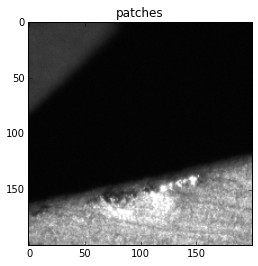

In [435]:
i = 7
plt.imshow(test_patches[i],cmap=plt.cm.gray)
plt.title(class_labels[r[i]])

In [418]:
def feature_extractor(im):
    #layer = 'fc7_cudanet_out'
    layer = 'fc6_cudanet_out'
    scores = net.classify((im*256).astype('uint8'),center_only=True)
    feature = net.feature(layer)
    return feature.flatten()

In [419]:
test_patches_feature = [feature_extractor(i) for i in test_patches]

In [420]:
r = classifier.predict(test_patches_feature)
for i in xrange(r.shape[0]):
    print i, le.classes_[r[i]]

0 Pa
1 Pa
2 PS
3 Pa
4 Pa
5 Sc
6 Cr
7 Pa
8 Sc
9 Pa
10 Pa
11 Pa
12 Pa
13 Sc
14 Cr
15 Pa
16 Sc
17 Sc
18 Sc
19 In
20 Cr
21 Pa
22 Cr
23 Cr
24 Cr
25 Pa
26 Cr
27 Pa
28 PS
29 Pa
30 Sc
31 Cr
32 Cr
33 Sc
34 In
35 Sc
36 Sc
37 Cr
38 Sc
39 Sc
40 Sc
41 Pa
42 Sc
43 Sc
44 Sc
45 Pa
46 Cr
47 Sc
48 Sc
49 Cr
50 Sc
51 Cr
52 Cr
53 Pa
54 Sc
55 Pa
56 Sc
57 Cr
58 Pa
59 Pa
60 Cr
61 Sc
62 Sc
63 Pa
64 Pa
65 Sc
66 Sc
67 Pa
68 Pa
69 Cr
70 Sc
71 Pa
72 Sc
73 Sc
74 Pa
75 Pa
76 Cr
77 Pa
78 Cr
79 Pa
80 Pa
81 Sc
82 Pa
83 Pa
84 Cr
85 Cr
86 RS
87 Cr
88 Sc
89 Sc
90 Pa
91 Pa
92 Pa
93 Sc
94 Pa
95 Sc
96 Cr
97 Sc
98 Pa
99 Cr


In [387]:
le.classes_

array(['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc'], 
      dtype='|S2')

In [187]:
X_avi = np.zeros((len(avi_names),4096))
for i in range(0,len(avi_names)):
    X_avi[i] = feature_extractor(avi_names[i])

In [188]:
pred_avi = classifier.predict(X_avi)

In [189]:
classifier.classes_,le.classes_

(array([0, 1, 2, 3, 4, 5]), array(['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc'], 
       dtype='|S2'))

In [208]:
for i in range(0,len(pred_avi)):
    if pred_avi[i] != 5:
        print pred_avi[i], avi_names[i].split('_')[-1].split('.')[0]

1 SecondaryGrain
3 Dirt (1)
2 Sliver (3)
3 Scuff (2)
3 MinusMetal
1 RX
2 RX (2)
3 Dirt (3)
3 Dirt (3)
3 SecondaryGrain (1)
4 Sliver (1)
1 Dent
3 SurfaceTexture (2)
3 Dent (1)
1 Shadowing (1)
1 Damage (5)
3 SecondaryGrain (4)
4 Sliver (2)
3 PoorBlast (1)
4 Damage (1)
4 Damage (2)
2 Sliver (1)
1 Damage (3)
3 Equiax (1)
3 PlusMetal (3)
3 PoorBlast (2)


# prepare data for text-image mapping

In [53]:
from gensim.models import Word2Vec
model = Word2Vec.load_word2vec_format("text_model/vectors-phrase.bin",binary=True)

In [66]:
print le.classes_

['Cr' 'In' 'PS' 'Pa' 'RS' 'Sc']


In [67]:
labels_dict = {}
labels_dict['Cr'] = 'crack'
labels_dict['In'] = 'inclusion'
labels_dict['PS'] = 'pit'
labels_dict['Pa'] = 'patch'
labels_dict['RS'] = 'roll'
labels_dict['Sc'] = 'scratch'

In [71]:
Y_vec = np.zeros((len(labels),100))
i = 0
for l in labels:
    Y_vec[i] = model[labels_dict[l]]
    i+= 1

In [73]:
with open("Y_100.pkl","w") as f:
    cPickle.dump(Y_vec,f)